# Linear Regression and Scraping
In this notebook, we will take the data scraped from IMDB and Box Office Mojo to create a linear regression model predicting the Worldwide box office gross for films with data available before the film's release. By choosing to use only information before release, we may give relevant parties an earlier estimate of their target.

In [6]:
import pandas as pd
import json
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.regression.linear_model as sm
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.cross_validation import cross_val_score
from sklearn import feature_selection as f_select
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import r2_score
from statsmodels.regression.linear_model import RegressionResults
from scipy.stats.mstats import zscore
%matplotlib inline

## Load the Data

In [8]:
# Load movie data
with open('data.json') as f:
    data = json.load(f)

In [9]:
# Load inflation data
inf_index = pd.read_csv('inflation.csv', header=None)
inf_index.columns = ['year', 'inflation']
inf_index.year = inf_index.year.str.replace('[^\d]*', '').astype(int)
inf_index.inflation = inf_index.inflation.str\
                                            .replace('[^\w]*', '')\
                                            .astype(float)\
                                            .apply(lambda x: x/10000)

In [10]:
# Load dataframe
df = pd.DataFrame(data)
df.drop(['download_latency', 'download_slot','download_timeout', 'depth'], axis=1, inplace=True)
df.columns.tolist()

['budget',
 'country',
 'director',
 'genre',
 'language',
 'lifetime',
 'mojo_url',
 'mpaa',
 'opening',
 'rating',
 'rating_count',
 'release',
 'runtime',
 'studio',
 'theaters',
 'title',
 'url',
 'worldwide',
 'year']

# Format and clean the data

In [11]:
# Replace None, nan, or n/a strings with np.nan
df = df.applymap(lambda x: np.nan if ((str(x).lower() == 'nan') or (str(x) == 'n/a') or (str(x) == 'None')) else x)

In [12]:
# Drop rows with nulls
df = df.dropna(how='any')
df.shape

(2370, 19)

In [13]:
def adjust_inflation(start_year, year):
    ci = 1
    for i in range(start_year, year + 1):
        ci *= (inf_index.loc[inf_index.year==i, 'inflation'].values + 1)
    return ci

In [14]:
# Type conversions
df.rating = df.rating.astype(float)
df.runtime = df.runtime.astype(float)
df.year = df.year.astype(int)


df.opening = df.opening.str.replace(r'[^\d]', '').astype(float)
df.theaters = df.theaters.str.replace(r'[^\d]', '').astype(float)
df.lifetime = df.lifetime.str.replace(r'[^\d]', '').astype(float)
df.worldwide = df.worldwide.str.replace(r'[^\d]', '').astype(float)


# Datetime
df.release = pd.to_datetime(df.release, format='%Y-%m-%d')
df['month_cat'] = df.release.dt.strftime('%B')

# Currency Convert
df = df[df.budget.apply(lambda x: str(x)[0]) == '$'] # Remove non-us budgets
df.budget = df.budget.str.replace(r'[^\d]', '').astype(float)

In [15]:
# Inflation Adjusted
start_year = 2000
l = ['opening', 'lifetime', 'worldwide', 'budget']
for e in l:
    df[str(e + '_adjusted')] = df.apply(lambda x: (x[e] * adjust_inflation(start_year, x['year'])), axis=1)[e]

# Log the money values
df['log_opening'] = np.log(df.opening)
df['log_lifetime'] = np.log(df.lifetime)
df['log_worldwide'] = np.log(df.worldwide)
df['log_budget'] = np.log(df.budget)

# Log inflation adjusted money values
df['log_opening_adjusted'] = np.log(df.opening_adjusted)
df['log_lifetime_adjusted'] = np.log(df.lifetime_adjusted)
df['log_worldwide_adjusted'] = np.log(df.worldwide)
df['log_budget_adjusted'] = np.log(df.budget_adjusted)

# Fix odd MPAA value
df.loc[df.mpaa =='PG-', 'mpaa'] = 'PG-13'
df.mpaa.value_counts()


R        967
PG-13    959
PG       332
G         41
NC-17      3
Name: mpaa, dtype: int64

In [18]:
def find_sig_cols(X, y, alpha=0.05):
    sig_cols = []
    for c in X.columns:
        pvalue = f_select.f_regression(X[[c]], y)[1][0]
        if pvalue <= alpha:
            sig_cols.append(c)

    return sig_cols

## Explore the relationships

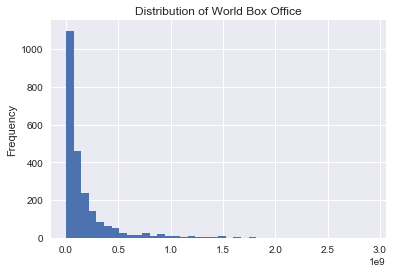

In [42]:
ax = df.worldwide_adjusted.plot(kind='hist', bins=40)
ax.set_title('Distribution of World Box Office')

In [19]:
# Release theaters divides opening
df_big = df[df.theaters > 50] #.plot(kind='hist', bins=40)
df_small = df[df.theaters < 50]
df_big.shape

(1845, 32)

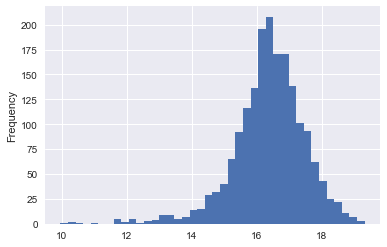

In [21]:
df_big.log_opening.plot(kind='hist', bins=40)

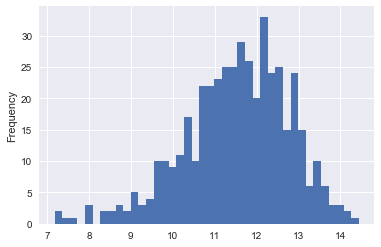

In [22]:
df_small.log_opening.plot(kind='hist', bins=40)

In [23]:
# Work with films with only high theater counts
df = df[df.theaters > 100]

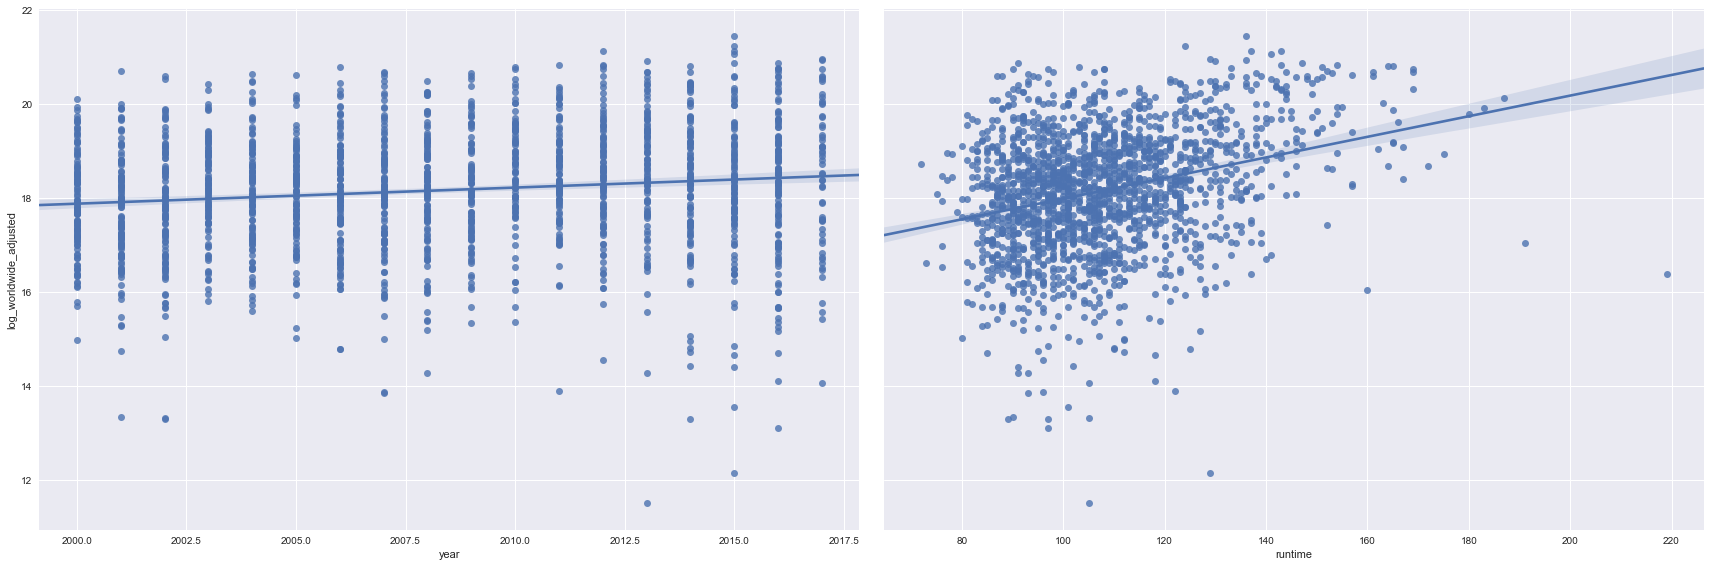

In [27]:
pp = sns.pairplot(data=df,
                  y_vars=['log_worldwide_adjusted'],
                  x_vars=['year','runtime'], kind='reg', size=8, aspect=1.5)

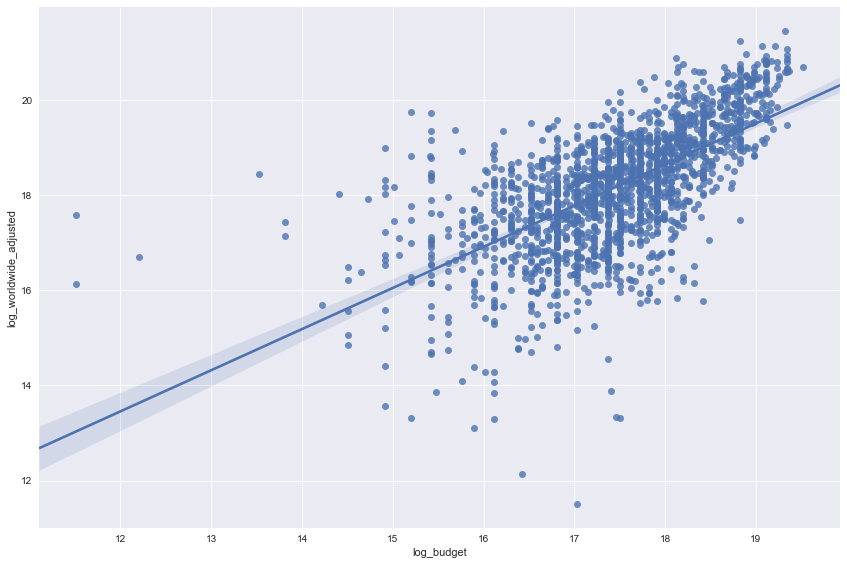

In [30]:
pp = sns.pairplot(data=df,
                  y_vars=['log_worldwide_adjusted'],
                  x_vars=['log_budget'], kind='reg', size=8, aspect=1.5)

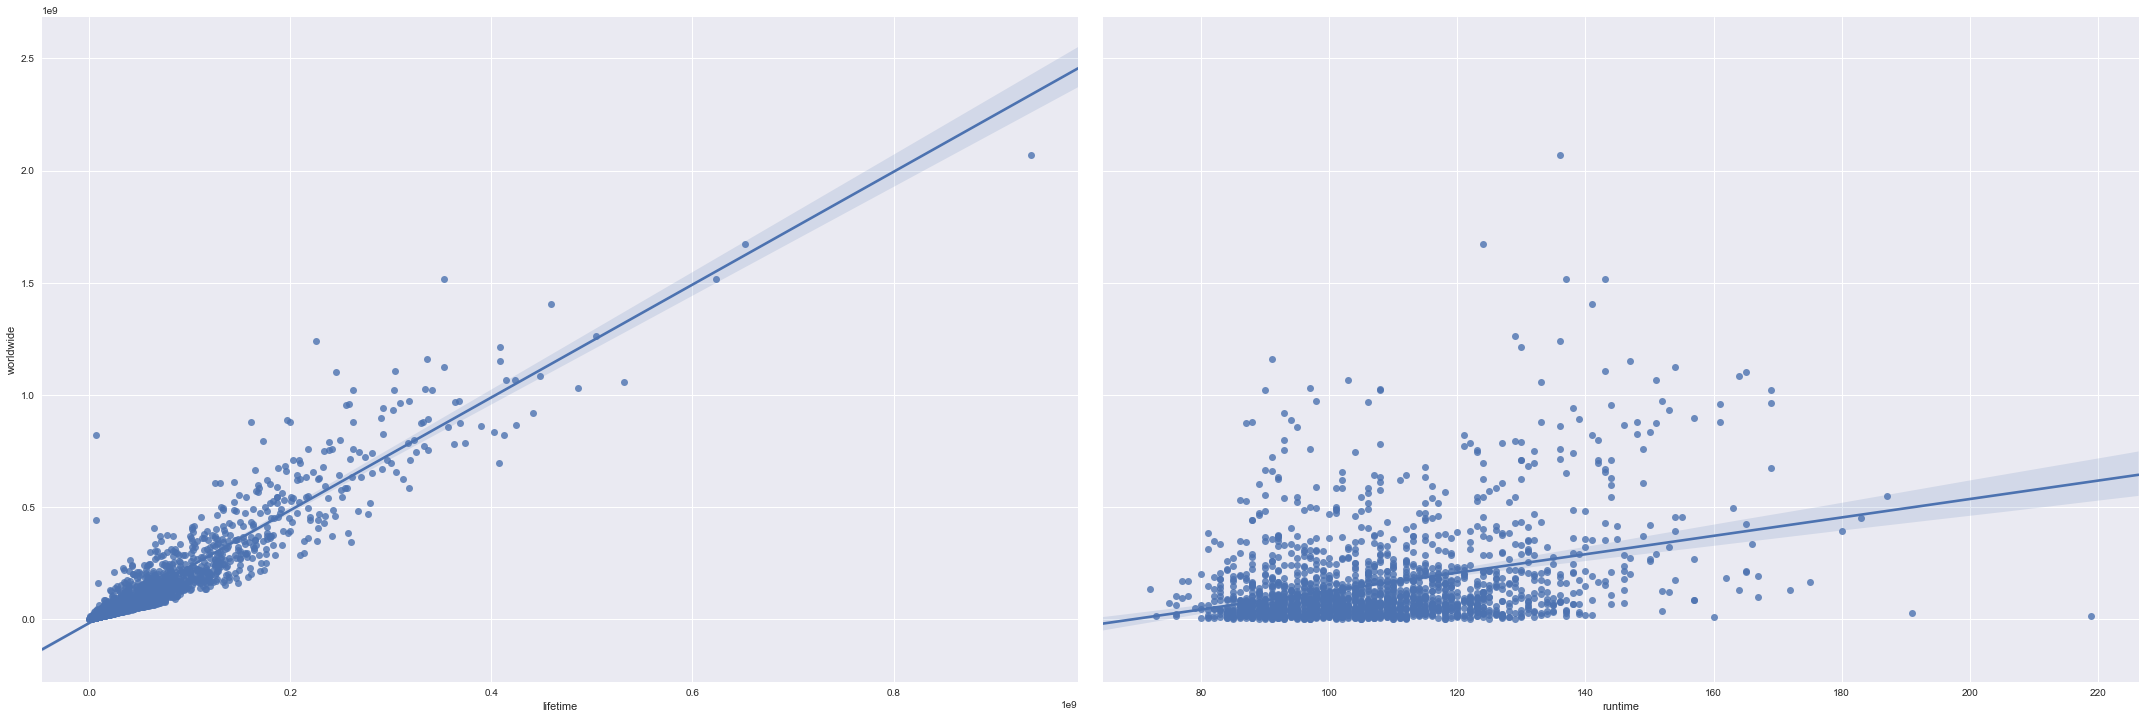

In [29]:
pp = sns.pairplot(data=df,
                  y_vars=['worldwide'],
                  x_vars=['lifetime', 'runtime'], kind='reg', size=10, aspect=1.5)

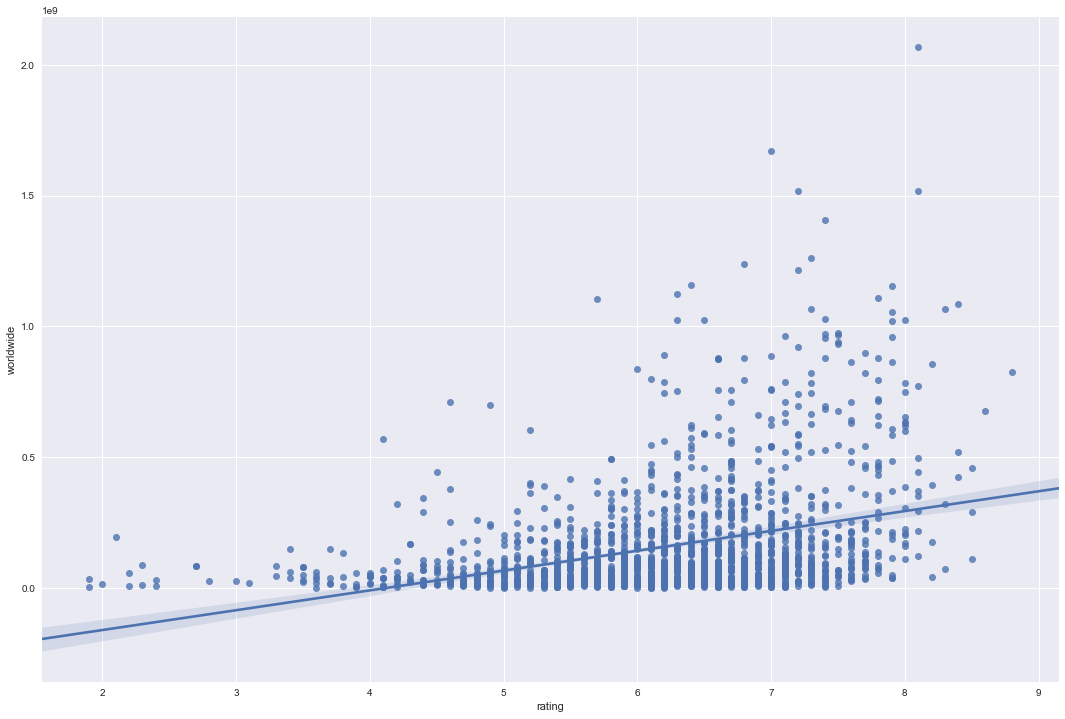

In [32]:
pp = sns.pairplot(data=df,
                  y_vars=['worldwide'],
                  x_vars=['rating'], kind='reg', size=10, aspect=1.5)

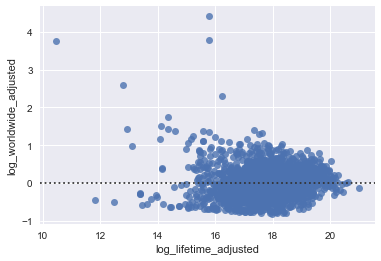

In [69]:
sns.residplot(x='log_lifetime_adjusted', y='log_worldwide_adjusted', data=df)

## Building the model

The following is a simple regression model with only the numerical features obtained.

In [25]:
# Standardize
df_work = df[['log_budget_adjusted', 'runtime', 'theaters', 'year']].apply(zscore, axis=0)
df_work['intercept'] = 1
model = sm.OLS(df.log_worldwide_adjusted, df_work)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     log_worldwide_adjusted   R-squared:                       0.649
Model:                                OLS   Adj. R-squared:                  0.648
Method:                     Least Squares   F-statistic:                     841.7
Date:                    Mon, 09 Oct 2017   Prob (F-statistic):               0.00
Time:                            07:52:06   Log-Likelihood:                -2108.4
No. Observations:                    1826   AIC:                             4227.
Df Residuals:                        1821   BIC:                             4254.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
log_budget_adjusted     0.2940      0.025     11.641      0.000       0.244       0.343
runtime                 0.1707      0.020      8.517      0.000       0.131       0.210
theaters                0.7964      0.024     33.376      0.000       0.750       0.843
year                   -0.0513      0.019     -2.752      0.006      -0.088      -0.015
intercept              18.1598      0.018   1009.351      0.000      18.124      18.195
==============================================================================
Omnibus:                      117.160   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              502.794
Skew:                           0.093   Prob(JB):                    6.60e-110
Kurtosis:                       5.564   Cond. No.                         2.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

To improve the model, we attempt to incorporate catagorical variables.

In [36]:
# Make top director column
top_5percent_directors = set(df.sort_values(by='lifetime', ascending=False).director.unique()[:int(df.director.unique().size * 0.05)])#.tolist()
df['top_director'] = df.director.apply(lambda x: 1 if (x in top_5percent_directors) else 0)

In [37]:
# Genre
genre_pre = df.set_index('title').genre.str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('genre')
dummy_genre = pd.get_dummies(genre_pre, prefix='g', columns=['genre']).groupby(level=0).sum().reset_index()
col = dummy_genre.columns.str.replace(' ', '')
dummy_genre.columns = col

In [39]:
# Month Dummy
df = pd.get_dummies(df, prefix='m', columns=['month_cat'])

In [42]:
# MPAA
df = pd.get_dummies(df, prefix='m', columns=['mpaa'])

In [43]:
# Country
df.country = df.country.str.replace(' ', '_')
country_pre = df.set_index('title').country.str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('country')
dummy_country = pd.get_dummies(country_pre, prefix='d', columns=['country']).groupby(level=0).sum().reset_index()
dummy_country.shape

(1826, 26)

In [38]:
# Language
#df.language = df.language.str.replace(' ', '_')
#language_pre = df.set_index('title').language.str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('language')
#dummy_language = pd.get_dummies(language_pre, prefix='l', columns=['language']).groupby(level=0).sum().reset_index()

In [44]:
# Merge all dummies
df_clean = df.merge(dummy_genre)
#df_clean = df_clean.merge(dummy_language)
df_clean = df_clean.merge(dummy_country)
df_clean.shape

(1826, 92)

In [49]:
# Used to build independant varibale dataframe
adj_feat = {
    'opening':0,
    'log_opening':0,
    'opening_adjusted':0,
    'log_opening_adjusted':0,
    'lifetime':0,
    'log_lifetime':0,
    'lifetime_adjusted':0,
    'log_lifetime_adjusted':0,
    'worldwide':0,
    'worldwide_adjusted':0,
    'log_worldwide':0,
    'log_worldwide_adjusted':0,
    'budget':0,
    'budget_adjusted':0,
    'log_budget':0,
    'log_budget_adjusted':1,
    'rating':0,
}

non_model = ['genre', 'director', 
               'url', 'language', 
               'country', 'mojo_url',
              'rating_count', 
               'studio', 'release',
             'title'
            ]

# Y dataframe
predict = 'log_worldwide_adjusted'
y = df_clean[predict]

# X Dataframe
for key,val in adj_feat.items():
    if not val:
        non_model.append(key)
        
X = df_clean.drop(non_model,axis=1)
X.columns.tolist()

['runtime',
 'theaters',
 'year',
 'log_budget_adjusted',
 'top_director',
 'm_April',
 'm_August',
 'm_December',
 'm_February',
 'm_January',
 'm_July',
 'm_June',
 'm_March',
 'm_May',
 'm_November',
 'm_October',
 'm_September',
 'm_G',
 'm_PG',
 'm_PG-13',
 'm_R',
 'g_Action',
 'g_Adventure',
 'g_Animation',
 'g_Biography',
 'g_Comedy',
 'g_Crime',
 'g_Drama',
 'g_Family',
 'g_Fantasy',
 'g_History',
 'g_Horror',
 'g_Music',
 'g_Musical',
 'g_Mystery',
 'g_Romance',
 'g_Sci-Fi',
 'g_Sport',
 'g_Thriller',
 'g_War',
 'g_Western',
 'd_Australia',
 'd_Belgium',
 'd_Canada',
 'd_Chile',
 'd_China',
 'd_Czech_Republic',
 'd_Denmark',
 'd_Finland',
 'd_France',
 'd_Germany',
 'd_Hong_Kong',
 'd_Ireland',
 'd_Japan',
 'd_Kenya',
 'd_Malta',
 'd_Mexico',
 'd_New_Zealand',
 'd_Panama',
 'd_Romania',
 'd_Russia',
 'd_South_Africa',
 'd_Spain',
 'd_UK',
 'd_USA',
 'd_United_Arab_Emirates']

In [70]:
X['intercept'] = 1
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     log_worldwide_adjusted   R-squared:                       0.696
Model:                                OLS   Adj. R-squared:                  0.685
Method:                     Least Squares   F-statistic:                     64.02
Date:                    Mon, 09 Oct 2017   Prob (F-statistic):               0.00
Time:                            08:13:14   Log-Likelihood:                -1977.3
No. Observations:                    1826   AIC:                             4083.
Df Residuals:                        1762   BIC:                             4435.
Df Model:                              63                                         
Covariance Type:                nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
runtime                    0.0098      0.001      6.877      0.000       0.007       0.013
theaters                   0.0009      3e-05     30.244      0.000       0.001       0.001
year                      -0.0125      0.004     -3.450      0.001      -0.020      -0.005
log_budget_adjusted        0.2494      0.029      8.526      0.000       0.192       0.307
top_director               0.3938      0.067      5.916      0.000       0.263       0.524
m_April                    1.9759      0.447      4.417      0.000       1.099       2.853
m_August                   2.1338      0.451      4.731      0.000       1.249       3.018
m_December                 2.4345      0.450      5.408      0.000       1.552       3.317
m_February                 2.0210      0.451      4.482      0.000       1.137       2.905
m_January                  2.1987      0.454      4.847      0.000       1.309       3.088
m_July                     2.2884      0.450      5.085      0.000       1.406       3.171
m_June                     2.2883      0.450      5.090      0.000       1.407       3.170
m_March                    2.0211      0.449      4.502      0.000       1.141       2.902
m_May                      2.2124      0.450      4.917      0.000       1.330       3.095
m_November                 2.2200      0.448      4.955      0.000       1.341       3.099
m_October                  2.0249      0.449      4.511      0.000       1.145       2.905
m_September                1.9290      0.451      4.278      0.000       1.045       2.813
m_G                        6.5151      1.336      4.876      0.000       3.894       9.136
m_PG                       6.4476      1.344      4.798      0.000       3.812       9.083
m_PG-13                    6.3874      1.339      4.770      0.000       3.761       9.014
m_R                        6.3979      1.342      4.766      0.000       3.765       9.031
g_Action                  -0.1040      0.049     -2.128      0.033      -0.200      -0.008
g_Adventure                0.0440      0.053      0.837      0.403      -0.059       0.147
g_Animation                0.2367      0.089      2.648      0.008       0.061       0.412
g_Biography               -0.0803      0.092     -0.870      0.384      -0.261       0.101
g_Comedy                  -0.1090      0.052     -2.086      0.037      -0.211      -0.007
g_Crime                   -0.1019      0.053     -1.913      0.056      -0.206       0.003
g_Drama                   -0.0200      0.046     -0.437      0.662      -0.109       0.070
g_Family                  -0.0597      0.103     -0.581      0.561      -0.261       0.142
g_Fantasy                 -0.0202      0.056     -0.360      0.719      -0.130       0.090
g_History                  0.1186   

We observe that using catagorical variables does improve our model's performance. However, in order to gauge real-world performance, we must evaluate how the model performs on data it has not seen yet. To do this, we use Sklearn's built-in methods to perform train/test splits and kfold cross-validation.

In [75]:
# Cross validate statsmodels
def evaluate_model(est, X, y, cv=10):
    
    # Traintest
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    est.fit(X_train,y_train)
    r2 = est.score(X_test,y_test)
    
    # Cross-validate
    cv_r2 = cross_val_score(est, X, y, cv=cv, scoring='r2')
    cv_r2_mean = sum(cv_r2)/len(cv_r2)
    mse = mean_squared_error(y, est.predict(X)) # Mean Square Error
    cv_mse =  cross_val_score(est, X, y, cv=cv, scoring='neg_mean_squared_error')
    cv_mse_mean = -sum(cv_mse)/len(cv_mse)
    
    #Repeated train/test split
    scores = []
    for i in range(cv):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        est.fit(X_train, y_train)
        scores.append(est.score(X_test, y_test))
    train = sum(scores)/len(scores)
    
    
    
    print("With {} columns".format(X.shape[1]))
    print("The MSE is {}".format(mse))
    print("The train/test split r-square is {}".format(r2))
    print("The cross-validated mean mse is {}".format(cv_mse_mean))
    print("The cross-validated mean r-squared is: {}".format(cv_r2_mean))
    print("Repeated train/test split yields a r-squared of {}".format(train))
    #print(cv_r2)


In [63]:
est = LinearRegression()
evaluate_model(est, X, y, 4)

With 67 columns
The MSE is 0.519154536446568
The train/test split r-square is 0.6810734182635036
The cross-validated mean mse is 0.630465524655134
The r-squared of the model is: 0.6924909790330914
The cross-validated mean r-squared is: 0.48161080375668697
Repeated train/test split yields a r-squared of 0.6641718571294759


There appears to be some overfitting. We attempt to use Ridge and Lasso models to see if there is an improvement

In [65]:
est = Ridge()
evaluate_model(est, X, y, 4)

With 67 columns
The MSE is 0.5186801163808343
The train/test split r-square is 0.6806550112318988
The cross-validated mean mse is 0.6265635150647646
The r-squared of the model is: 0.6891279295492125
The cross-validated mean r-squared is: 0.48499076514726747
Repeated train/test split yields a r-squared of 0.668919793559394


In [67]:
est = Lasso()
evaluate_model(est, X, y, 4)

With 67 columns
The MSE is 0.6431284062463656
The train/test split r-square is 0.5815818050527314
The cross-validated mean mse is 0.7065193879652201
The r-squared of the model is: 0.6179581913094898
The cross-validated mean r-squared is: 0.4221121494284834
Repeated train/test split yields a r-squared of 0.611578549382612


The model appears to perform worse with penalities on complexity. Perhaps it may be our alpha that is not correctly set.

In [68]:
def plot_alpha(X,y, estimator, title):    #X.describe().T
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    colors = sns.hls_palette(2)

    n_steps = 5
    degree = 9
    a_exp = np.linspace(-15,1,num=n_steps)
    alpha_range = [10**a for a in a_exp] 
    #alpha_range = [0.1, 0.5, 1, 5, 10]
    
    train_error = np.empty(n_steps)
    test_error = np.empty(n_steps)
    coefs = []
    train_error_r2 = np.empty(n_steps)
    test_error_r2 = np.empty(n_steps)
    

    for i,alpha in enumerate(alpha_range):
        est = estimator(alpha=alpha, normalize=True)
        est.fit(X_train, y_train)

        train_error_r2[i] = est.score(X_test, y_test)#mean_squared_error(y_train, est.predict(X_train))
        test_error_r2[i] = est.score(X_test, y_test)#mean_squared_error(y_test, est.predict(X_test))

        train_error[i] = mean_squared_error(y_train, est.predict(X_train))
        test_error[i] = mean_squared_error(y_test, est.predict(X_test))
        coefs.append(est.coef_)


    # Plot the training and test errors against degree

    fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=True, figsize=(12,5), sharex=True)

    fig.suptitle(title)
    axes[0].plot(alpha_range, train_error, label='train', color=colors[0])
    axes[0].plot(alpha_range, test_error, label='test', color=colors[1])
    axes[0].set_ylabel('mean squared error')
    axes[0].set_xlabel('log($\lambda$)')
    axes[0].legend(loc='upper right')
    
    axes[1].plot(alpha_range, train_error_r2, label='train', color=colors[0])
    axes[1].plot(alpha_range, test_error_r2, label='test', color=colors[1])
    axes[1].set_ylabel('r-squared')
    axes[1].set_xlabel('log($\lambda$)')
    axes[1].legend(loc='upper right')

/home/jvheeswijck/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.142785024709152e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


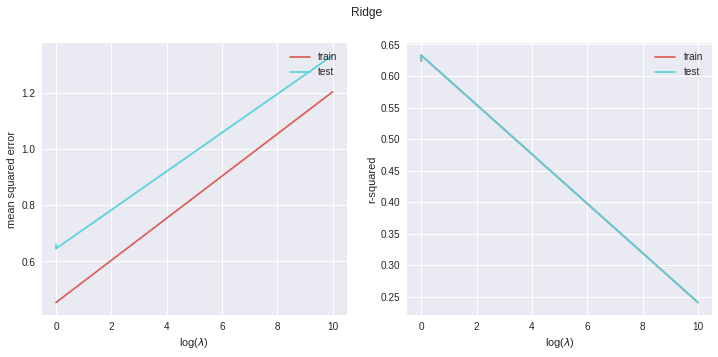

In [356]:
plot_alpha(X,y, Ridge, "Ridge")

/home/jvheeswijck/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


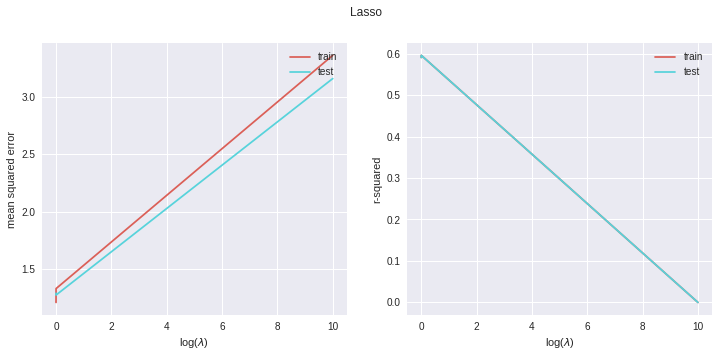

In [76]:
plot_alpha(X,y, Lasso, 'Lasso')

It is apparent that regardless of our parameter alpha, these two models perform no better than a simple linear regression. We try another method to reduce overfitting by using p-value selection to choose features with statistically significant correlations.

In [78]:
sig_cols = find_sig_cols(X, y)
sig_cols[:5]

C:\Users\JvHeeswijck\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
C:\Users\JvHeeswijck\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\JvHeeswijck\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\JvHeeswijck\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


['runtime', 'theaters', 'year', 'log_budget_adjusted', 'top_director']

In [76]:
est = LinearRegression()
evaluate_model(est, X[sig_cols], y, 4)

# Previous performance
'''With 67 columns
The MSE is 0.519154536446568
The train/test split r-square is 0.6810734182635036
The cross-validated mean mse is 0.630465524655134
The r-squared of the model is: 0.6924909790330914
The cross-validated mean r-squared is: 0.48161080375668697
Repeated train/test split yields a r-squared of 0.6641718571294759'''

With 42 columns
The MSE is 0.5332860659935014
The train/test split r-square is 0.6262473009906571
The cross-validated mean mse is 0.6285030024948322
The cross-validated mean r-squared is: 0.48320292178431307
Repeated train/test split yields a r-squared of 0.6887179454485465


After using a p-value test to select features, we observe that ther is a very slight improvement to the model. We also reduce the number of features, resulting in a simpler model.

In [81]:
# Find the beta coefficients
betas =[x + ' ' + str(y) for x,y in sorted(list(zip(X[sig_cols].columns.tolist(),est.coef_)), key=lambda x: abs(x[1]), reverse=True)]

To visualize the performance of the model, we create a Y-Y' plot. From this plot, we can see where the model overfits, underfits, and where follows the data well.

In [87]:
def plot_yy(est, y, X):
    fig,ax = plt.subplots(figsize=(12,5))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    est.fit(X_train,y_train)
    ax.scatter(y_test, est.predict(X_test))
    x = np.linspace(11, 22, 50)
    ax.plot(x,x, color='red')
    ax.set_ylabel('Predicted')
    ax.set_xlabel('Actual')
    #ax.plot(x='actual', y='predicted', data=pd.DataFrame(list(zip(y, est.predict(X))), columns=['actual', 'predicted']))

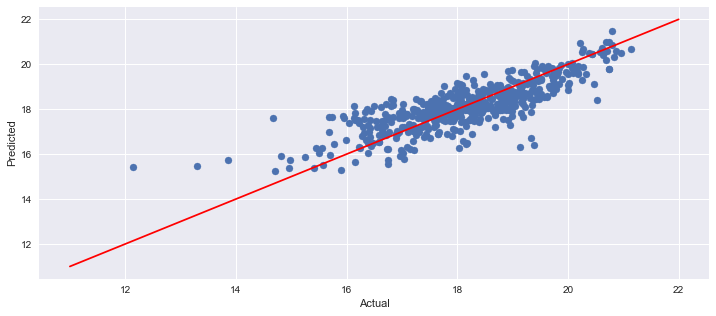

In [88]:
est = LinearRegression()
plot_yy(est, y, X)

The model overpredicts the worldbox office for low actual worldbox office values however above log(16), or around 9 million USD< the model does a decent job of estimating total worldwide boxoffice gross.

Viewing the residual model to see if the data if the residuals are evenly distributed.

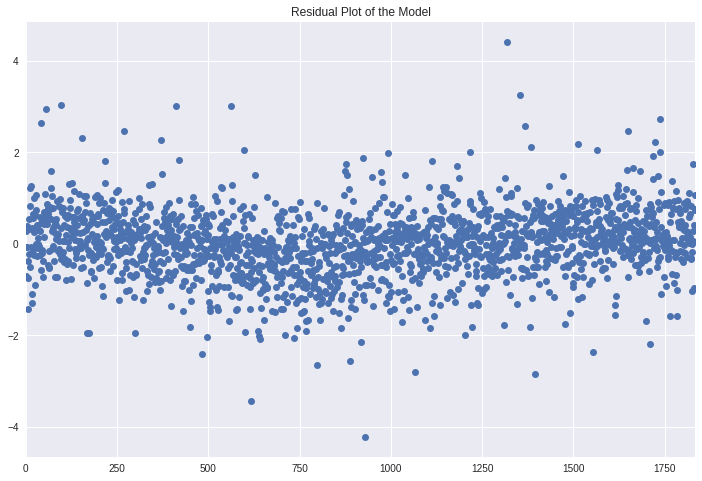

In [91]:
ax = fit.resid.plot(style='o', figsize=(12,8))
ax.set_title('Residual Plot of the Model')